# Data Description

Data was gathered from the city of Chicago's public dataset: [2001 to present - Dashboard](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g). API documentation can be found at [Socrata](https://dev.socrata.com/foundry/data.cityofchicago.org/ijzp-q8t2). Data was then loaded into a local MySQL database for analytics purposes. 

### Columns Available
* `id` = unique identified
* `case_number` = Chicago Police Department RD Number
* `date` = timestamp when incident occurred
* `block` = The partially redacted address where the incident occurred, placing it on the same block as the actual address
* `iucr` = The Illinois Uniform Crime Reporting code
* `primary_type` = The primary description of the IUCR code
* `description` = The secondary description of the IUCR code, a subcategory of the primary description
* `location_description` = Description of the location where the incident occurred
* `arrest` = Indicates whether an arrest was made
* `domestic` = Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act
* `beat` = Indicates the beat where the incident occurred
* `district` = Indicates the police district where the incident occurred
* `ward` = The ward (City Council district) where the incident occurred
* `community_area` = Indicates the community area where the incident occurred
* `fbi_code` = Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS)
* `x_coordinate` = The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection
* `y_coordinate` = The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection
* `year` = Year the incident occurred
* `updated_on` = Date and time the record was last updated
* `latitude` = The latitude of the location where the incident occurred
* `longitude` = The longitude of the location where the incident occurred
* `location` (not retrieved) = The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal
* `month` (custom) = The month when the incident occurred. Derived from `date`.
* `ymd` (custom) = The year, month and day when the incident occurred. Derived from `date` 

### Data Retrieval Process

1. Request API keys. See the [API documentation on Socrata](https://dev.socrata.com/foundry/data.cityofchicago.org/ijzp-q8t2)
2. Download MySQL to your local machine and setup a MySQL server
3. Create the object which to retrieves data from the API and interacts with your MySQL server: `CrimeData.py`
4. Write some driver code to utilize your data object which creates a database and uploads data: `main.py`
5. Access your database and retrieve the desired subset of data using SQL queries: `various_queries.sql`

The data used for this analysis was pulled on 2023-08-01, note that data retrieved is up to the most recent day minus 7 days. For this reason, we must exclude the most recent month, year or day which does not have complete data for that time period if we want accurate results.

### Data Aggregation

Data was aggregated into a few datasets for the count of incidents by year, month and day. SQL code for aggregation can be found in the `various_queries.sql` file located in the `dbscripts` directory.

In [15]:
import pandas as pd

In [16]:
# crime counts by year
cc_year = pd.read_csv('../data/cc_yearly_20230801.csv')
cc_year.head()

,year,yearly_crimes
0,2001,485878
1,2002,486799
2,2003,475984
3,2004,469419
4,2005,453769


In [17]:
# crime counts by month
cc_month = pd.read_csv('../data/cc_monthly_20230801.csv')
cc_month.head()

,year,month,monthly_crimes
0,2001,1,38119
1,2001,2,33787
2,2001,3,40566
3,2001,4,40091
4,2001,5,41839


In [18]:
# crime counts by day
cc_day = pd.read_csv('../data/cc_daily_20230801.csv')
cc_day.head()

,ymd,daily_crimes
0,2001-01-01,1825
1,2001-01-02,1143
2,2001-01-03,1151
3,2001-01-04,1166
4,2001-01-05,1267


### Time Plots

As described previously, the data retrieved is up to the most recent day minus 7 days. For this reason, we must exclude the most recent year, month and day, since we may not have complete data for that time period.

#### Yearly

In [19]:
import matplotlib.pyplot as plt

In [20]:
# Use .iloc to slice the DataFrame and exclude the last row
cc_year = cc_year.iloc[:-1]

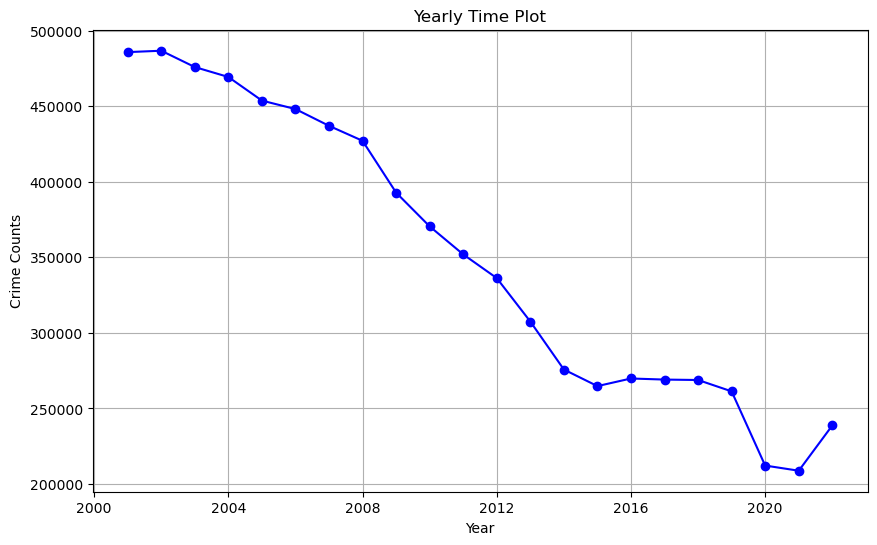

In [21]:
cc_year['year'] = pd.to_datetime(cc_year['year'], format='%Y')

cc_year.set_index('year', inplace=True)

# Create a yearly time plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(cc_year.index, cc_year['yearly_crimes'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.title('Yearly Time Plot')
plt.grid(True)
plt.show()

The yearly plot of the counts of crime in the city of chicago show a steady decrease in overall crime between the years of 2001-2022 (2023 excluded). Something interesting to note is that we see a sharp drop during 2019-2021, likely due to the Covid-19 pandemic. In 2022 however, this drop in crime does not hold and increases, returning to presumably "normal" levels. 

#### Monthly

In [22]:
# Use .iloc to slice the DataFrame and exclude the last row
cc_month = cc_month.iloc[:-1]

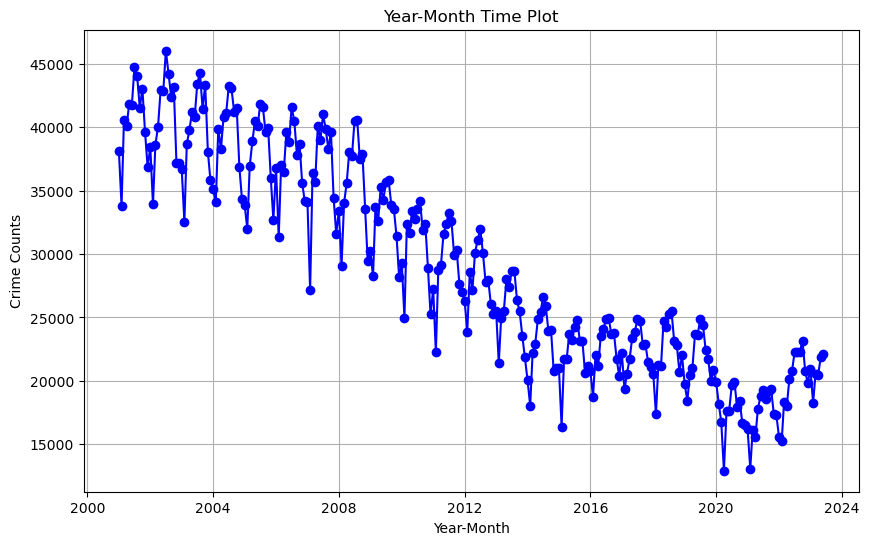

In [23]:
# Create a column with year month data and assign it to the index
cc_month['y-m'] = pd.to_datetime(cc_month[['year', 'month']].assign(day=1))
cc_month.set_index('y-m', inplace=True)

# Create a time plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(cc_month.index, cc_month['monthly_crimes'], marker='o', linestyle='-', color='b')
plt.xlabel('Year-Month')
plt.ylabel('Crime Counts')
plt.title('Year-Month Time Plot')
plt.grid(True)
plt.show()

From the year-month time plot, it's quite clear that our data has a seasonal component and a decreasing linear trend. Visually, the seasonal component does seem to decrease in variance as time steps increase as well. Our observations regarding the 2019-2021 Covid-19 pandemic seem to hold for this monthly data as well.

#### Daily

In [24]:
# Use .iloc to slice the DataFrame and exclude the last row
cc_day = cc_day.iloc[:-1]

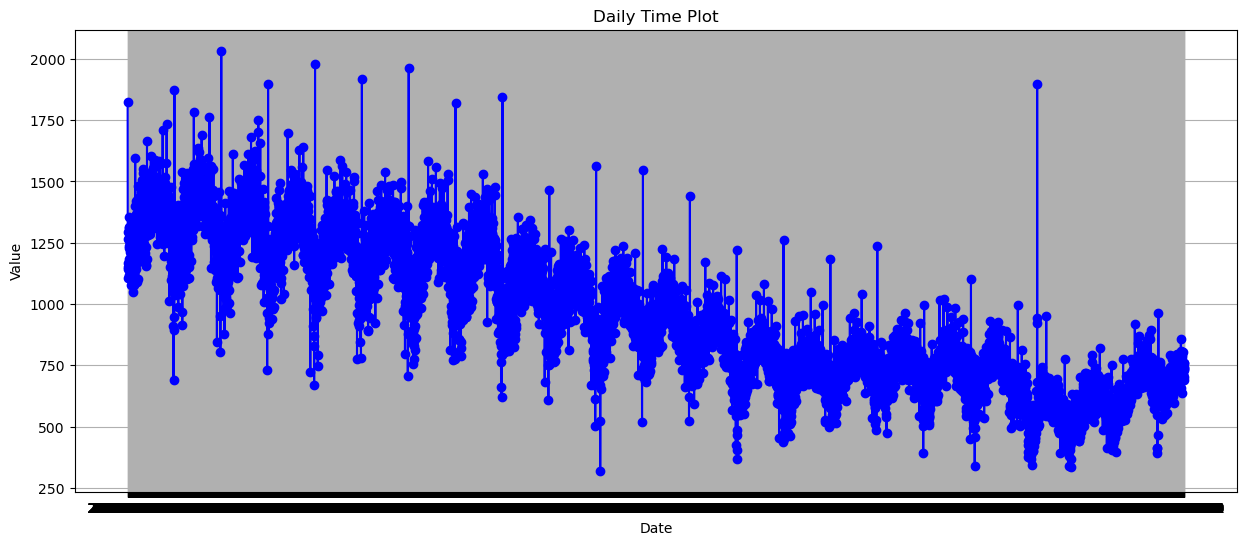

In [25]:
cc_day.set_index('ymd', inplace=True)

# Create a time plot using matplotlib
plt.figure(figsize=(15, 6))
plt.plot(cc_day.index, cc_day['daily_crimes'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Daily Time Plot')
plt.grid(True)
plt.show()

We can draw many of the same conclusions from the daily data as we can from the monthly data. However, there is something interesting to note: at certain points in time, the counts of crime seem to spike dramatically. These spikes seem to occur at the beginning and the end of every year, and intermittently through-out. It's unclear what these points in time correspond to, maybe they are holidays (were incidents of crime presumably spike), or maybe the individuals who entered the data points just entered them all at once on specific days. 

# Final Data Set

We've decided on performing a time series analysis using the monthly counts dataset. 

In [26]:
def export_df(dataframe, output_file_path):
    # Export the modified DataFrame to a CSV file
    dataframe.to_csv(output_file_path, index=False)

In [29]:
export_df(cc_month,'../data/cc_monthly_final.csv')